Searching for CSV files in: d:\solar_energy_forecast\data\raw
Found 194 files:
- colchester_001.csv
- colchester_002.csv
- colchester_003.csv
- colchester_004.csv
- colchester_006.csv
...

Columns in colchester_001.csv:
['datetime', 'temp', 'dew', 'humidity', 'precip', 'precipprob', 'preciptype', 'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'solarradiation', 'uvindex']

Columns in colchester_002.csv:
['Unnamed: 0', 'datetime', 'temp', 'dew', 'humidity', 'precip', 'precipprob', 'preciptype', 'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex']

Columns in colchester_003.csv:
['datetime', 'temp', 'dew', 'humidity', 'precip', 'precipprob', 'preciptype', 'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex']

Columns in colchester_004.csv:
['datetime', 'temp', 'dew', 'humidity', 'precip', 'precipprob', 'preciptype', 'sno

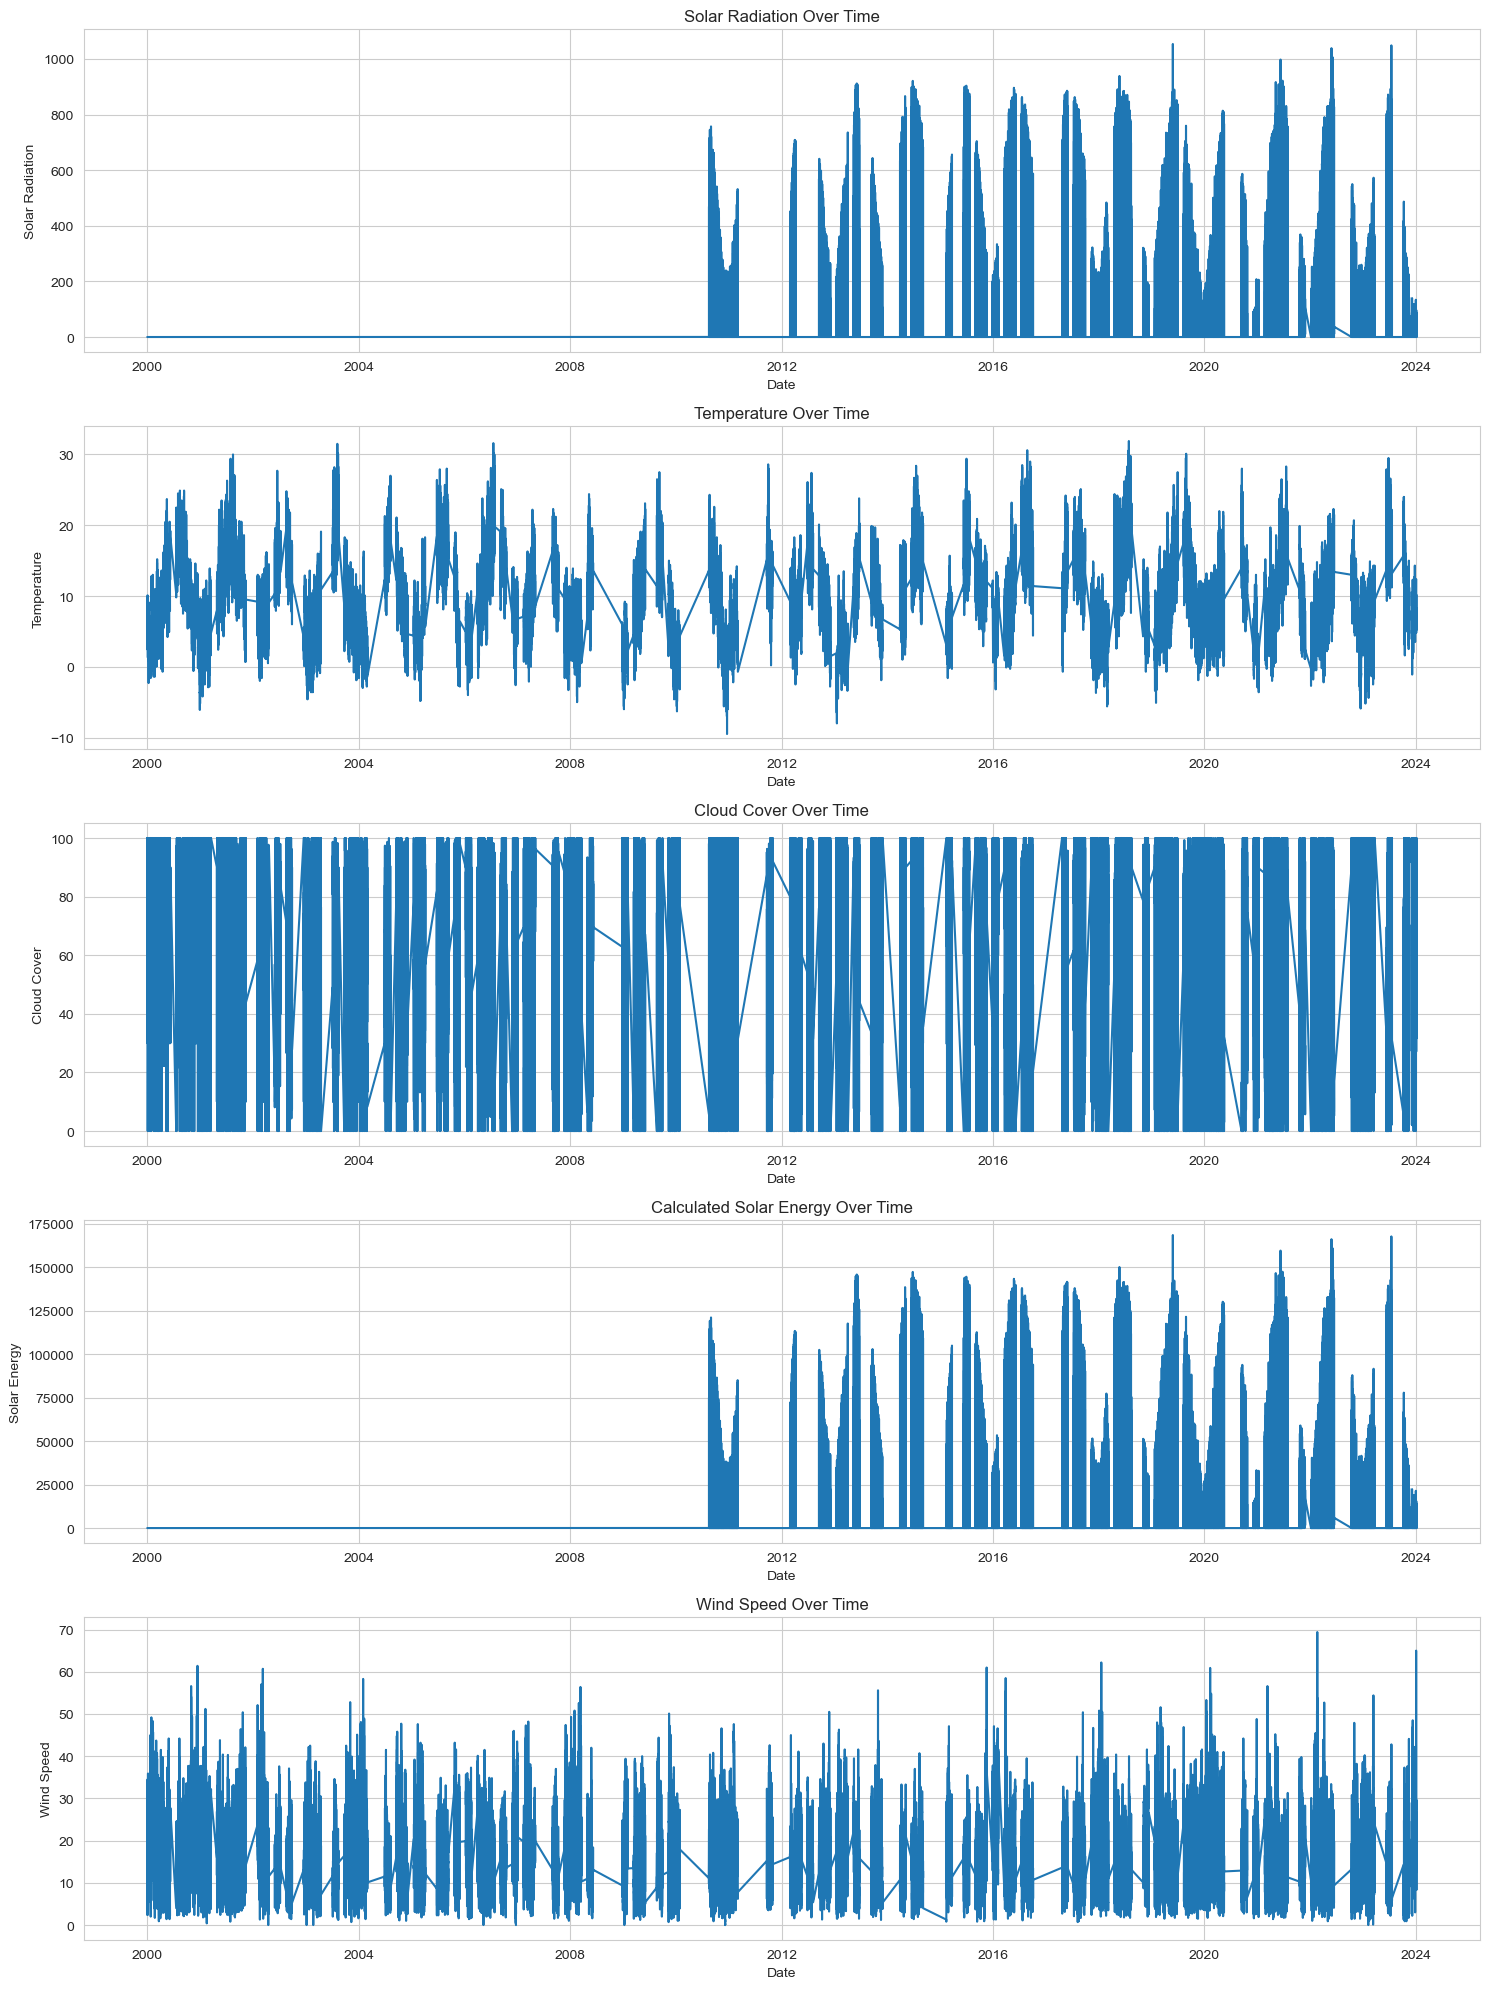

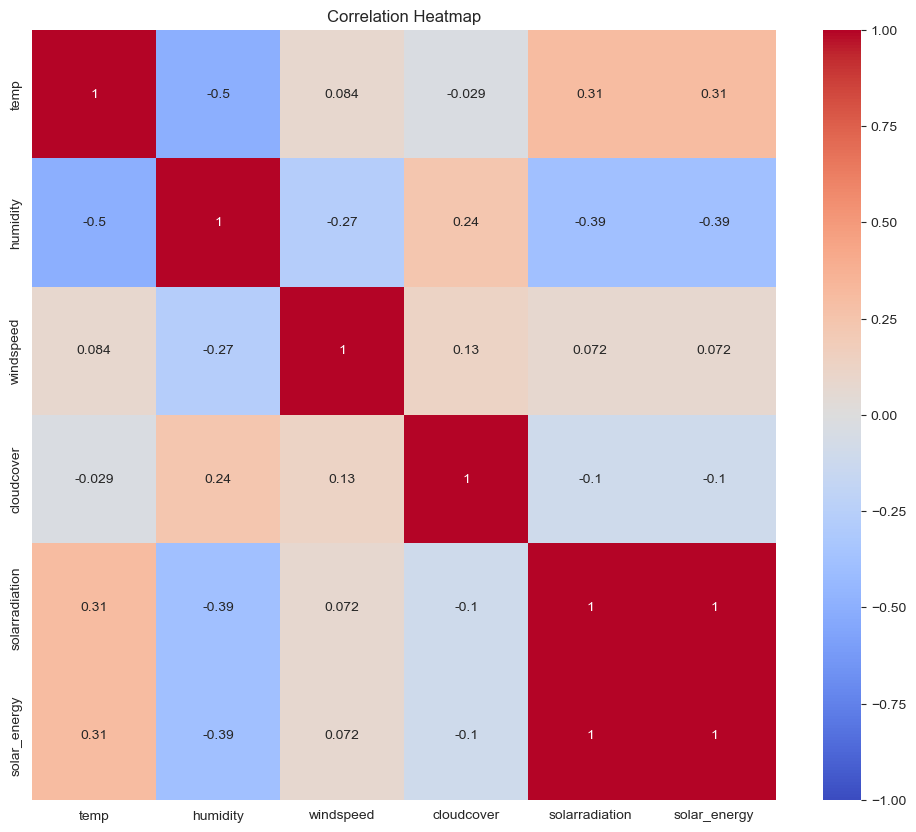


Calculated threshold: 60000.00 kWh


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from datetime import datetime

project_root = os.path.dirname(os.getcwd())
data_path = os.path.join(project_root, "data", "raw")
processed_data_path = os.path.join(project_root, "data", "processed")

os.makedirs(processed_data_path, exist_ok=True)

np.random.seed(42)

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

def load_all_csv_files(data_path):
    """
    Loading and merging all CSV files from the specified directory
    """
    print(f"Searching for CSV files in: {os.path.abspath(data_path)}")
    
    all_files = glob.glob(os.path.join(data_path, "colchester_*.csv"))
    
    print(f"Found {len(all_files)} files:")
    for file in all_files[:5]:
        print(f"- {os.path.basename(file)}")
    if len(all_files) > 5:
        print("...")
    
    if not all_files:
        raise ValueError(f"No CSV files found in {data_path}. Please check the directory path.")
    
    df_list = []
    for filename in all_files:
        try:
            df = pd.read_csv(filename, nrows=5)
            print(f"\nColumns in {os.path.basename(filename)}:")
            print(df.columns.tolist())

            if 'datetime' in df.columns:
                df = pd.read_csv(filename, parse_dates=['datetime'])
            else:
                df = pd.read_csv(filename)
                print(f"Warning: 'datetime' column not found in {os.path.basename(filename)}")
            
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {os.path.basename(filename)}: {str(e)}")
    
    if not df_list:
        raise ValueError("No valid CSV files could be read.")
    
    df_combined = pd.concat(df_list, axis=0, ignore_index=True)
    
    return df_combined

#We load the data
df = load_all_csv_files(data_path)
print(f"\nShape of the combined dataframe: {df.shape}")

print("\nColumns in the combined dataframe:")
print(df.columns.tolist())

print("\nFirst few rows of the combined dataframe:")
print(df.head())

print("\nMissing values in the combined dataframe:")
print(df.isnull().sum())

print("\nStatistical summary of the combined dataframe:")
print(df.describe())

df = load_all_csv_files(data_path)
print(f"\nShape of the combined dataframe: {df.shape}")

df = df.sort_values('datetime')

features = ['datetime', 'temp', 'humidity', 'windspeed', 'cloudcover', 'solarradiation']
df = df[features]

df = df.drop_duplicates()

df['solarradiation'] = df['solarradiation'].fillna(0)
df = df.dropna() 

def calculate_solar_energy(df):
    """
    Calculate solar energy production based on solar radiation
    Assuming 500 solar panels with standard efficiency
    """
    num_panels = 500
    panel_efficiency = 0.2 
    panel_area = 1.6  
    
    df['solar_energy'] = (df['solarradiation'] * num_panels * 
                         panel_efficiency * panel_area)
    return df

df = calculate_solar_energy(df)

print("\nDataset Info:")
print(df.info())

print("\nFirst few rows of the dataset:")
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nStatistical summary:")
print(df.describe())

plt.figure(figsize=(15, 20))
plt.subplot(5, 1, 1)
plt.plot(df['datetime'], df['solarradiation'])
plt.title('Solar Radiation Over Time')
plt.xlabel('Date')
plt.ylabel('Solar Radiation')

plt.subplot(5, 1, 2)
plt.plot(df['datetime'], df['temp'])
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')

plt.subplot(5, 1, 3)
plt.plot(df['datetime'], df['cloudcover'])
plt.title('Cloud Cover Over Time')
plt.xlabel('Date')
plt.ylabel('Cloud Cover')

plt.subplot(5, 1, 4)
plt.plot(df['datetime'], df['solar_energy'])
plt.title('Calculated Solar Energy Over Time')
plt.xlabel('Date')
plt.ylabel('Solar Energy')

plt.subplot(5, 1, 5)
plt.plot(df['datetime'], df['windspeed'])
plt.title('Wind Speed Over Time')
plt.xlabel('Date')
plt.ylabel('Wind Speed')

plt.tight_layout()
plt.savefig(os.path.join(project_root, "results", "figures", "time_series_plots.png"))
plt.show()

correlation_matrix = df[features[1:] + ['solar_energy']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.savefig(os.path.join(project_root, "results", "figures", "correlation_heatmap.png"))
plt.show()

def calculate_threshold():
    N_colchester = 75000 
    N_pilot = N_colchester * 0.12 
    E = 0.5 
    K = 5 
    threshold = N_pilot * E * K + N_colchester * E
    return threshold

threshold = calculate_threshold()
print(f"\nCalculated threshold: {threshold:.2f} kWh")

output_path = os.path.join(processed_data_path, "processed_data.csv")
df.to_csv(output_path, index=False)